In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
embs=np.load('scotus_embeddings.npy')
print(embs.shape)

(35781, 3072)


In [8]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist

# Load embeddings
embs = np.load('scotus_embeddings.npy')

# Sample a subset to make it tractable
np.random.seed(42)
sample = embs[np.random.choice(embs.shape[0], size=1000, replace=False)]

# Normalize for cosine distance
sample_norm = normalize(sample, norm='l2')

# Compute pairwise cosine distance (1 - cosine similarity)
D = pdist(sample_norm, metric='cosine')

# Contrast Ratio
nonzero_D = D[D > 0]

d_min = nonzero_D.min()
d_max = nonzero_D.max()
contrast_ratio = (d_max - d_min) / d_min if d_min > 0 else np.nan

print("=== COSINE DISTANCE (filtered) ===")
print(f"Mean (nonzero): {nonzero_D.mean():.4f}")
print(f"Min: {d_min:.4f}, Max: {d_max:.4f}")
print(f"Contrast Ratio: {contrast_ratio:.4f}")

low = np.percentile(nonzero_D, 1)
high = np.percentile(nonzero_D, 99)
robust_contrast_ratio = (high - low) / low

print("=== COSINE DISTANCE (robust) ===")
print(f"1st percentile: {low:.4f}")
print(f"99th percentile: {high:.4f}")
print(f"Robust Contrast Ratio: {robust_contrast_ratio:.4f}")



=== COSINE DISTANCE (filtered) ===
Mean (nonzero): 0.5407
Min: 0.0000, Max: 0.8182
Contrast Ratio: 930400.6814
=== COSINE DISTANCE (robust) ===
1st percentile: 0.3260
99th percentile: 0.7155
Robust Contrast Ratio: 1.1947


In [9]:
from scipy.spatial.distance import pdist

# Sample 1000 raw vectors (no normalization)
np.random.seed(42)
sample_euc = embs[np.random.choice(embs.shape[0], size=1000, replace=False)]

# Compute Euclidean distances
D_euc = pdist(sample_euc, metric='euclidean')

# Filter zeros (if any)
nonzero_D_euc = D_euc[D_euc > 0]

# Basic contrast
d_min_euc = nonzero_D_euc.min()
d_max_euc = nonzero_D_euc.max()
contrast_euc = (d_max_euc - d_min_euc) / d_min_euc

# Robust contrast
low_euc = np.percentile(nonzero_D_euc, 1)
high_euc = np.percentile(nonzero_D_euc, 99)
robust_contrast_euc = (high_euc - low_euc) / low_euc

# Output
print("=== EUCLIDEAN DISTANCE (no normalization) ===")
print(f"Mean Distance: {nonzero_D_euc.mean():.4f}")
print(f"Min: {d_min_euc:.4f}, Max: {d_max_euc:.4f}")
print(f"Contrast Ratio: {contrast_euc:.4f}")
print(f"Robust Contrast (1–99%): {robust_contrast_euc:.4f}")


=== EUCLIDEAN DISTANCE (no normalization) ===
Mean Distance: 1.0364
Min: 0.0013, Max: 1.2792
Contrast Ratio: 963.5733
Robust Contrast (1–99%): 0.4815


[{'pca_components': 250, 'metric': 'euclidean', 'robust_contrast': np.float64(0.6235931646996139)}, {'pca_components': 250, 'metric': 'cosine', 'robust_contrast': np.float64(1.0697597877788774)}, {'pca_components': 250, 'metric': 'correlation', 'robust_contrast': np.float64(1.0701068489316725)}, {'pca_components': 500, 'metric': 'euclidean', 'robust_contrast': np.float64(0.5508385296337655)}, {'pca_components': 500, 'metric': 'cosine', 'robust_contrast': np.float64(0.8984033951828942)}, {'pca_components': 500, 'metric': 'correlation', 'robust_contrast': np.float64(0.8985713739883149)}, {'pca_components': 750, 'metric': 'euclidean', 'robust_contrast': np.float64(0.525666113940121)}, {'pca_components': 750, 'metric': 'cosine', 'robust_contrast': np.float64(0.8352201338579822)}, {'pca_components': 750, 'metric': 'correlation', 'robust_contrast': np.float64(0.8353382870027746)}, {'pca_components': 1000, 'metric': 'euclidean', 'robust_contrast': np.float64(0.5131359968866158)}, {'pca_compon

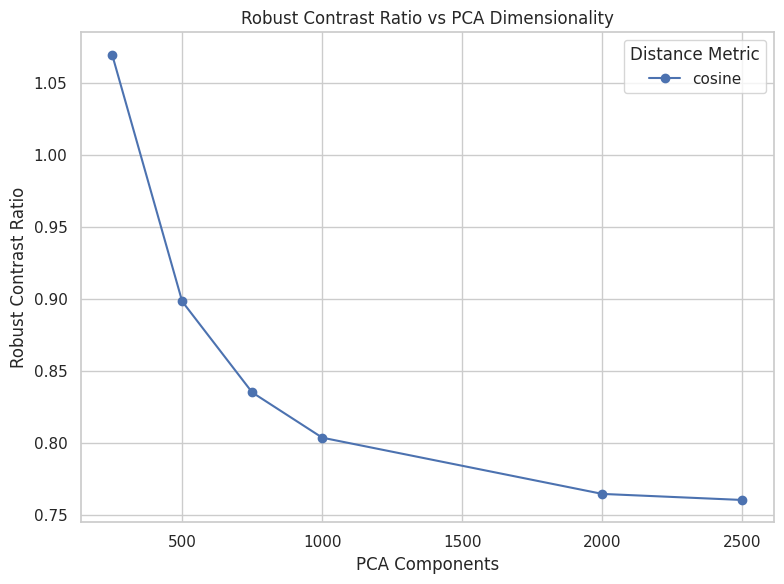

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist
import seaborn as sns

def compute_robust_contrast(distances):
    nonzero_D = distances[distances > 0]
    if len(nonzero_D) == 0:
        return np.nan
    low = np.percentile(nonzero_D, 1)
    high = np.percentile(nonzero_D, 99)
    return (high - low) / low if low > 0 else np.nan

def contrast_by_metric_and_pca(data, metrics, pca_components_list):
    results = []
    for n_components in pca_components_list:
        if n_components < data.shape[1]:
            pca = PCA(n_components=n_components)
            data_pca = pca.fit_transform(data)
        else:
            data_pca = data

        for metric in metrics:
            if metric == 'cosine':
                data_proc = normalize(data_pca, norm='l2')
            else:
                data_proc = data_pca

            distances = pdist(data_proc, metric=metric)
            contrast = compute_robust_contrast(distances)

            results.append({
                'pca_components': n_components,
                'metric': metric,
                'robust_contrast': contrast
            })
    print(results)
    return results

def plot_contrast(results):
    import pandas as pd
    df = pd.DataFrame(results)

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    for metric in df['metric'].unique():
        #if metric=='cosine':
            #subset = df[df['metric'] == metric]
            #plt.plot(subset['pca_components'], subset['robust_contrast'], marker='o', label=metric)
        subset = df[df['metric'] == metric]
        plt.plot(subset['pca_components'], subset['robust_contrast'], marker='o', label=metric)

    plt.title("Robust Contrast Ratio vs PCA Dimensionality")
    plt.xlabel("PCA Components")
    plt.ylabel("Robust Contrast Ratio")
    plt.legend(title="Distance Metric")
    plt.tight_layout()
    plt.show()

# === MAIN ===
if __name__ == "__main__":
    # Load your SCOTUS embeddings
    embs = np.load('scotus_embeddings.npy')

    # Sample for memory efficiency
    np.random.seed(42)
    sample = embs[np.random.choice(embs.shape[0], size=5000, replace=False)]

    # Set up config
    metrics = ['euclidean', 'cosine', 'correlation']
    pca_components_list = [250, 500, 750, 1000, 2000, 2500]

    # Run analysis
    results = contrast_by_metric_and_pca(sample, metrics, pca_components_list)

    # Plot
    plot_contrast(results)


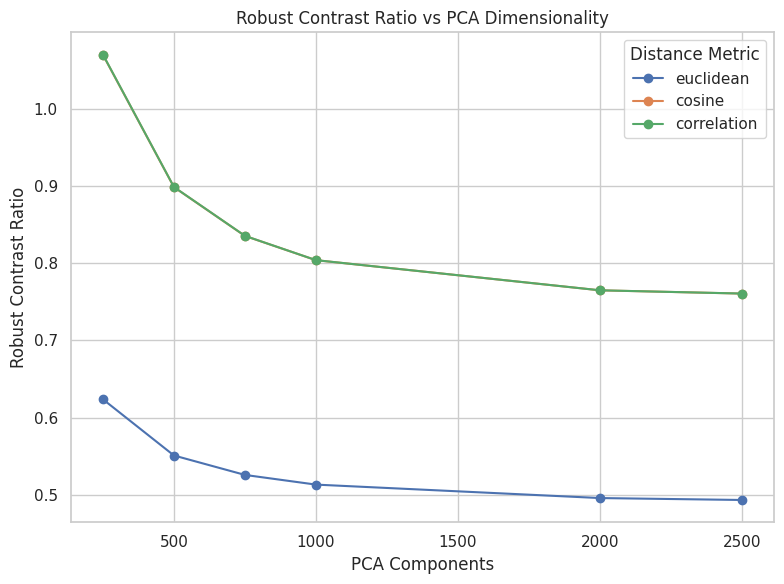

In [14]:
def plot_contrast(results):
    import pandas as pd
    df = pd.DataFrame(results)

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    for metric in df['metric'].unique():
        #if metric=='cosine':
            #subset = df[df['metric'] == metric]
            #plt.plot(subset['pca_components'], subset['robust_contrast'], marker='o', label=metric)
        subset = df[df['metric'] == metric]
        plt.plot(subset['pca_components'], subset['robust_contrast'], marker='o', label=metric)

    plt.title("Robust Contrast Ratio vs PCA Dimensionality")
    plt.xlabel("PCA Components")
    plt.ylabel("Robust Contrast Ratio")
    plt.legend(title="Distance Metric")
    plt.tight_layout()
    plt.show()
plot_contrast(results)

In [16]:
!pip install kneed

In [17]:
from kneed import KneeLocator
import pandas as pd

# Convert results to DataFrame if needed
df = pd.DataFrame(results)

# Choose the metric you're interested in (e.g. 'cosine')
selected_metric = 'cosine'
metric_df = df[df['metric'] == selected_metric].sort_values('pca_components')

# Extract PCA dims and contrast scores
pca_dims = metric_df['pca_components'].values
contrast_scores = metric_df['robust_contrast'].values

# Use KneeLocator to find the "elbow" point
knee = KneeLocator(pca_dims, contrast_scores, curve='convex', direction='decreasing')
optimal_pca = knee.knee

print(f"📐 Optimal PCA dimensionality for '{selected_metric}' metric based on contrast: {optimal_pca}")


📐 Optimal PCA dimensionality for 'cosine' metric based on contrast: 750
